In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import warnings
warnings.filterwarnings("ignore")

In [41]:
import os
from pathlib import Path
from tqdm import tqdm
import matplotlib.pyplot as plt
import random
from shutil import copyfile

In [4]:
from fastai import *
from fastai.vision import *
from fastai.callbacks import *

In [5]:
path = Path('/data/Datasets/EIPH_WSI/Patches_train_val/')

In [6]:
def get_float_labels(x: Path):
    return float(x.parent.stem)

In [7]:
tfms = get_transforms(do_flip=True, 
                      flip_vert=True, 
                      max_rotate=90,  
                      max_lighting=0., 
                      max_zoom=1.1, 
                      #max_warp=0.2,
                      #p_affine=0.75,
                      #p_lighting=0.75,  
                      #xtra_tfms=xtra_tfms,
                     )

In [8]:
data = (ImageList.from_folder(path)
 .split_by_folder(train="train", valid="val")
 .label_from_func(get_float_labels, label_cls=FloatList)
 .transform(tfms, size=128)
 .databunch(bs=64)).normalize()

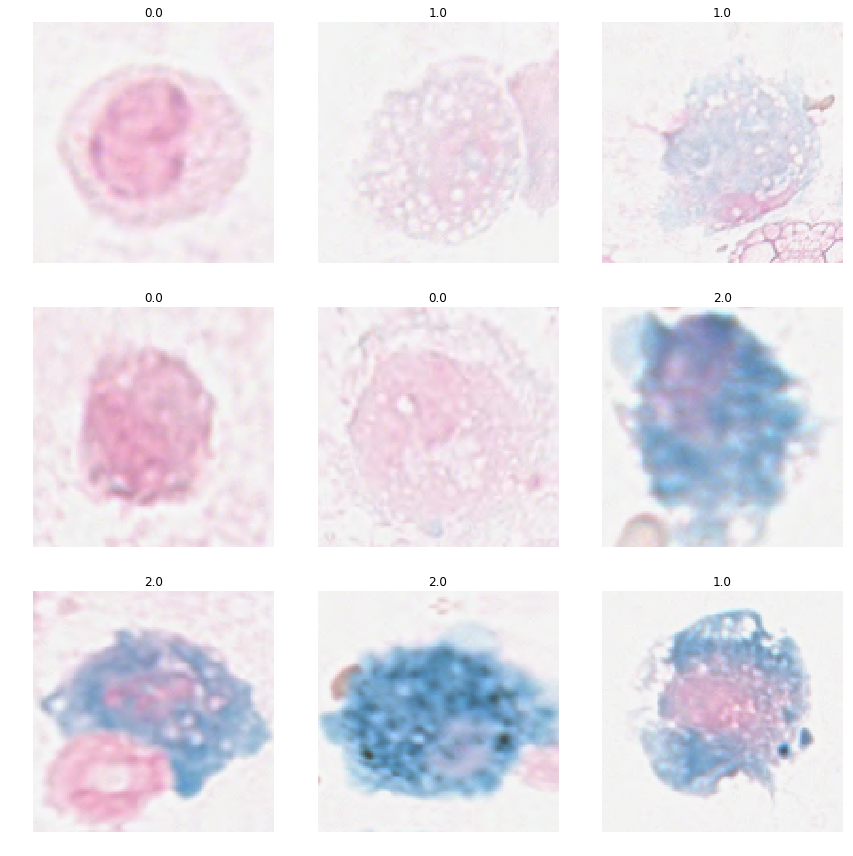

In [9]:
fig = data.show_batch(rows=3)

In [45]:
class L1LossFlat(nn.L1Loss):
    #Mean Absolute Error Loss
    def forward(self, input:Tensor, target:Tensor) -> Rank0Tensor:
        return super().forward(input.view(-1), target.view(-1))

In [10]:
def create_regression_head(nf:int, nc:int, y_range=[-0.5,4.5],
                           lin_ftrs:Optional[Collection[int]]=None, ps:Floats=0.5, bn_final:bool=False):
    "Model head that takes `nf` features, runs through `lin_ftrs`, and about `nc` classes."
    lin_ftrs = [nf, 512, nc] if lin_ftrs is None else [nf] + lin_ftrs + [nc]
    ps = listify(ps)
    if len(ps)==1: ps = [ps[0]/2] * (len(lin_ftrs)-2) + ps
    actns = [nn.ReLU(inplace=True)] * (len(lin_ftrs)-2) + [None]
    layers = [AdaptiveConcatPool2d(), Flatten()]
    for ni,no,p,actn in zip(lin_ftrs[:-1],lin_ftrs[1:],ps,actns):
        layers += bn_drop_lin(ni,no,True,p,actn)
    if bn_final: layers.append(nn.BatchNorm1d(lin_ftrs[-1], momentum=0.01))
    if y_range is not None: layers.append(SigmoidRange(*y_range))
    return nn.Sequential(*layers)

In [11]:
head = create_regression_head(1024, 1)

In [12]:
head

Sequential(
  (0): AdaptiveConcatPool2d(
    (ap): AdaptiveAvgPool2d(output_size=1)
    (mp): AdaptiveMaxPool2d(output_size=1)
  )
  (1): Flatten()
  (2): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (3): Dropout(p=0.25)
  (4): Linear(in_features=1024, out_features=512, bias=True)
  (5): ReLU(inplace)
  (6): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (7): Dropout(p=0.5)
  (8): Linear(in_features=512, out_features=1, bias=True)
  (9): SigmoidRange()
)

In [13]:
learn = create_cnn(data, models.resnet18, callback_fns=[ShowGraph], custom_head=head)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


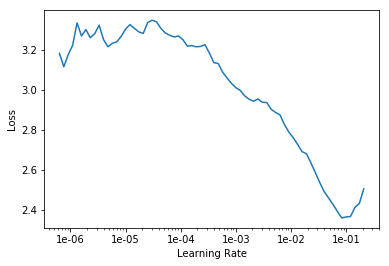

In [23]:
learn.lr_find()
learn.recorder.plot()

epoch,train_loss,valid_loss,time
0,0.183384,0.150419,00:58
1,0.149296,0.127514,00:57
2,0.126246,0.124495,00:57
3,0.122594,0.118061,00:57
4,0.119359,0.113934,00:58


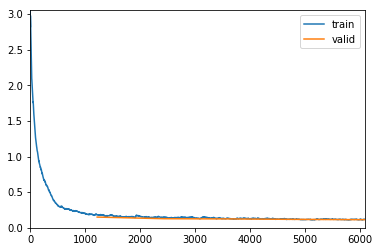

In [14]:
lr = 0.01
learn.fit_one_cycle(5, slice(lr))

In [15]:
learn.unfreeze()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


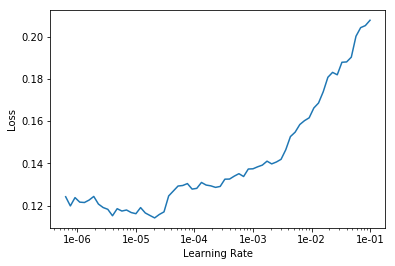

In [16]:
learn.lr_find()
learn.recorder.plot()

epoch,train_loss,valid_loss,time
0,0.120860,0.096027,00:59
1,0.119809,0.093287,01:00
2,0.116748,0.097872,00:59
3,0.115189,0.093067,01:00
4,0.108995,0.088854,00:59
5,0.105664,0.088400,01:00
6,0.107645,0.086914,00:59
7,0.099855,0.086432,00:59
8,0.103132,0.085627,01:00
9,0.096922,0.085806,00:59


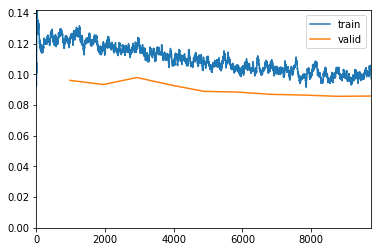

In [52]:
lr = 0.001
learn.fit_one_cycle(10, slice(1e-5, lr/5))

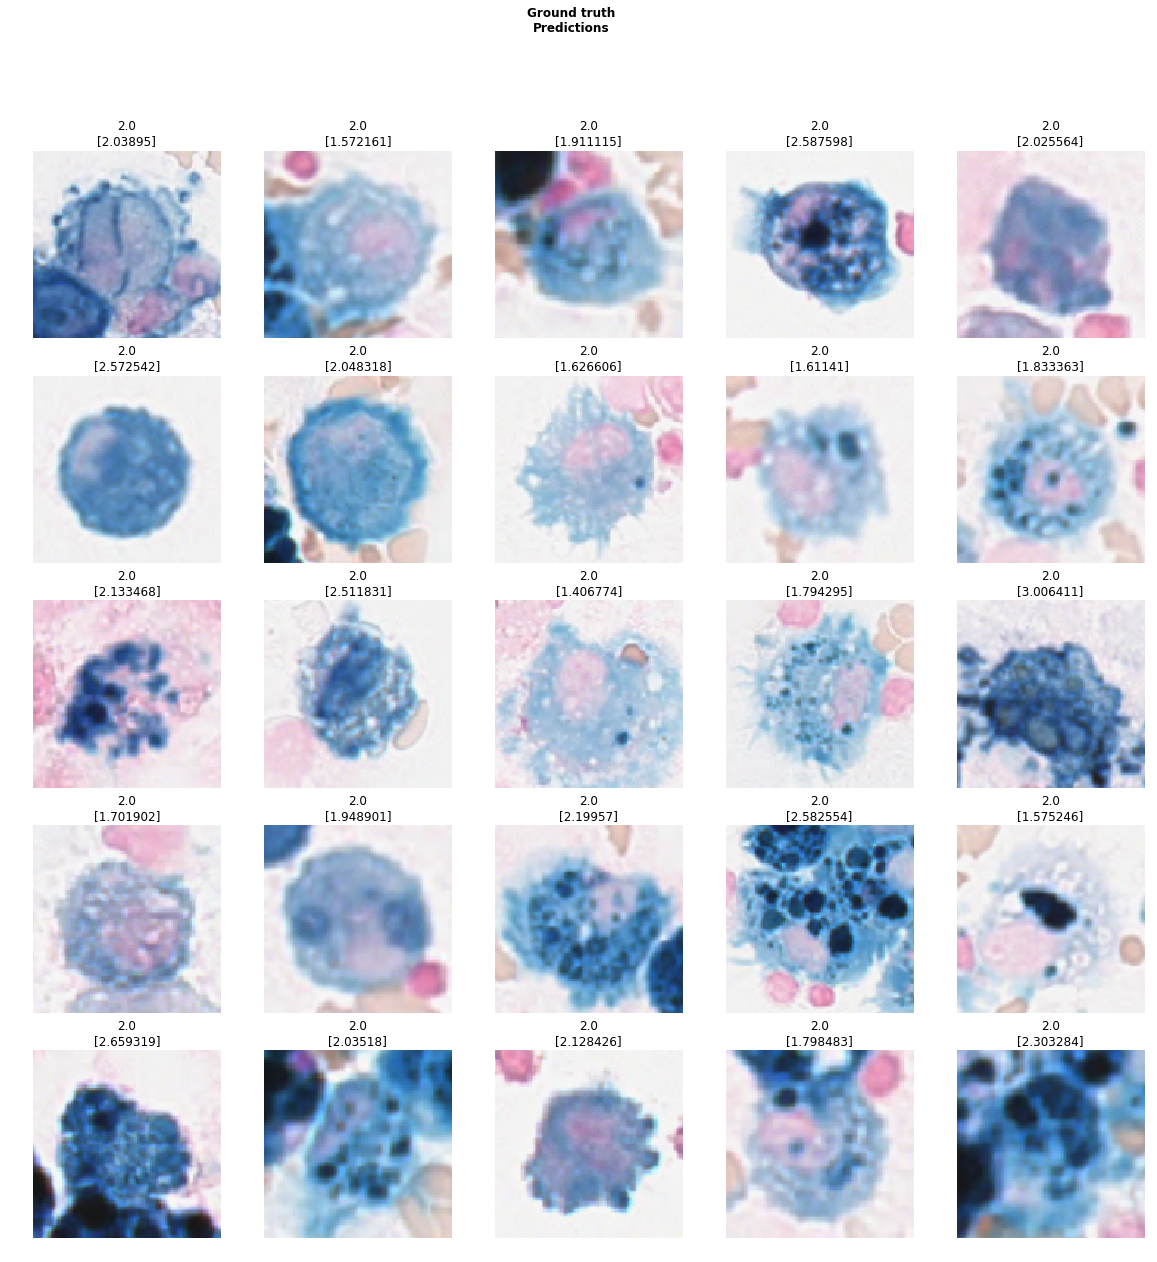

In [29]:
learn.show_results()

In [23]:
y_pred, y_true = learn.get_preds(ds_type=DatasetType.Valid)

In [25]:
y_pred = to_np(y_pred).flatten()
y_true = to_np(y_true).astype(np.uint)

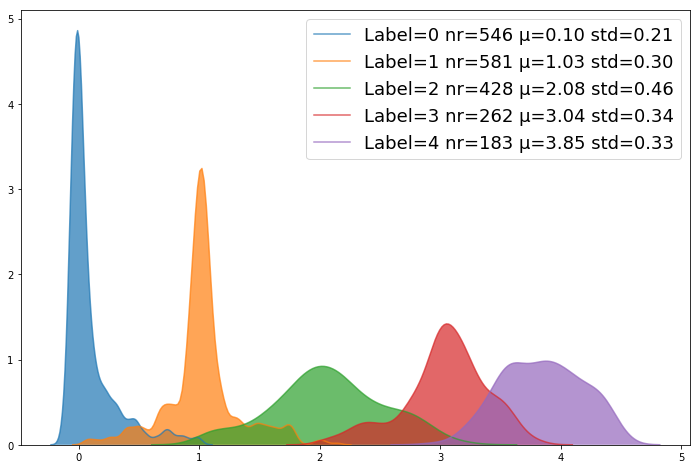

In [34]:
import seaborn as sns
plt.figure(figsize=(12, 8))

for i in set(y_true): 
    y_pred_temp = y_pred[np.where(y_true == i)]
    mean = np.mean(y_pred_temp)
    std = np.std(y_pred_temp)
    label="Label={} Σ={} µ={:1.2f} std={:1.2f}".format(i, len(y_pred_temp),  mean, std)
    
    sns.kdeplot(y_pred_temp, shade=True, label=label, alpha=.7) #, color="g"

#plt.title('Density Plot of City Mileage by n_Cylinders', fontsize=22)
plt.legend(fontsize=18)
plt.savefig("RegressionResults.pdf", transparent=True)
plt.show()

In [36]:
np.mean(y_pred)

1.5196149

In [43]:
np.mean(np.round(y_pred).astype(int))

1.5085

In [42]:
preds_test, _ = learn.get_preds(ds_type=DatasetType.Valid)
values, indices = torch.max(preds_test, 1)

v0 = Path("/data/Datasets/EIPH_WSI/HumanExpert/DL_Regression/v0/")
for fn, y in zip(learn.data.valid_dl.items, np.round(y_pred).astype(int)):
    target_path =  v0/"{0}/{1}".format(y, fn.name)
    copyfile(str(fn), str(target_path))

In [44]:
preds_test, _ = learn.get_preds(ds_type=DatasetType.Valid)
values, indices = torch.max(preds_test, 1)

v0 = Path("/data/Datasets/EIPH_WSI/HumanExpert/DL_Regression/v1/")
for fn, y in zip(learn.data.valid_dl.items, np.round(y_pred).astype(int)):
    target_path =  v0/"{0}/{1}".format(y, fn.name)
    copyfile(str(fn), str(target_path))